# Processing cleaned data for visualization

In [1]:
import pandas as pd 
import numpy as np 
import sqlite3 as sql
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm_notebook

# PCA & CLUSTERING
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
RANDOM_STATE = 17 # Fixed random state for reproductivity 

## Part 1. 
_NO NEED TO RUN AGAIN - GO TO PART 2_

#### Retrieve data from database
- pickle preserve multidimensional compenent unlike SQLite

In [2]:
conn = sql.connect("data/data.db")
cur = conn.cursor()
df = pd.read_sql_query("SELECT * FROM stock_index", conn)
conn.close()

In [3]:
df.head(1)

,Ticker,YQuarter,gsector,X1_REVGH,X2_EPS,X3_ROA,X4_ROE,X5_PE,X6_PS,X7_NPM,...,X13_EM,X14_EVCFO,X15_LTDTA,X16_WCR,X17_DE,X18_QR,X19_DSI,X20_DPO,y_return,Date
0,A,1999Q3,35,0.038308,0.36,0.026733,0.041925,119.270833,7.81804,0.064686,...,-32.860525,127.695785,0.0,2.219496,0.568323,1.130879,632.218004,168.644252,0.932748,1999-07-31 00:00:00


#### Scale Data 

In [4]:
# Scale features only 
scaler = MinMaxScaler(feature_range=[0, 1]) #10 - 100
scaled_data = pd.DataFrame(scaler.fit_transform(df.drop(['Date','gsector','Ticker', 'YQuarter'],axis=1)))
# Scaled data names 
scaled_data.columns = df.drop(["YQuarter","Ticker" , 'gsector', 'Date'],axis=1).columns
scaled_data.min().min(), scaled_data.max().max()

(0.0, 1.0000000000000002)

In [5]:
scaled_data.head(1)

,X1_REVGH,X2_EPS,X3_ROA,X4_ROE,X5_PE,X6_PS,X7_NPM,X8_GPM,X9_OM,X10_PB,...,X12_CR,X13_EM,X14_EVCFO,X15_LTDTA,X16_WCR,X17_DE,X18_QR,X19_DSI,X20_DPO,y_return
0,0.000267,0.251872,0.791643,0.974791,0.515213,0.000012,0.943751,0.978899,0.998973,0.883918,...,0.000036,0.555422,0.870439,0.0,0.018988,0.411435,0.009822,0.092728,0.293428,0.678461


#### PCA 
Choosing number of PCA components from [Medium Blog](https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe)

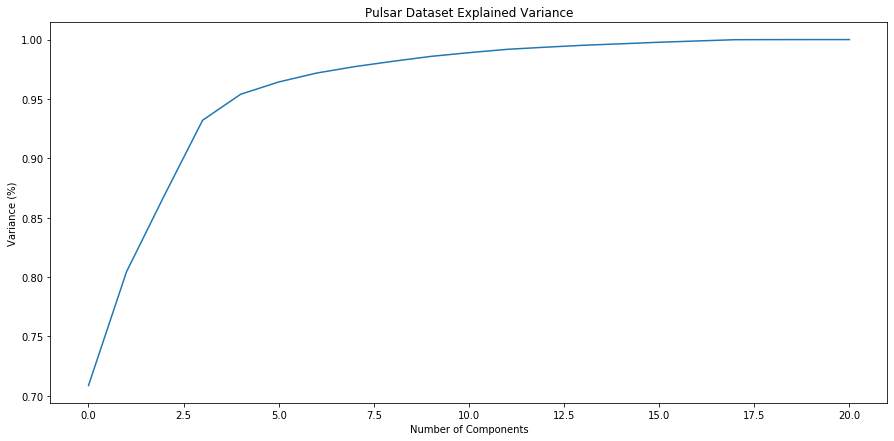

In [9]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(scaled_data)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize = (15,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [10]:
# Apply PCA on features
pca = PCA(n_components=12) 
df_pca= pd.DataFrame(pca.fit_transform(scaled_data))
# Rename columns 
df_pca.columns = ["PCA_"+str(x+1) for x in range(pca.components_.shape[0])]
print ("shape of df_pca", df_pca.shape) # sample
df_pca.head(1)

shape of df_pca (79231, 12)


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12
0,-0.085916,-0.005973,-0.08238,0.037696,-0.001543,-0.001425,-0.000367,0.0001,0.000303,0.000051,-0.000362,-0.000199


In [11]:
print("{}s principal components required to cover 90% of the variance of the original (scaled) data\n".format(df_pca.shape[1]))
print("Amount of explained variance by componenet: \n",pd.Series(pca.explained_variance_).head())
print("\n The 3 five principal components explain {}% of the dataset's variance.".format(round(pd.Series(pca.explained_variance_ratio_).head(3).sum(),2)*100))

12s principal components required to cover 90% of the variance of the original (scaled) data

Amount of explained variance by componenet: 
 0    0.005048
1    0.000683
2    0.000461
3    0.000448
4    0.000156
dtype: float64

 The 3 five principal components explain 87.0% of the dataset's variance.


Text(0.5, 1.0, 'Cumulative explained variance')

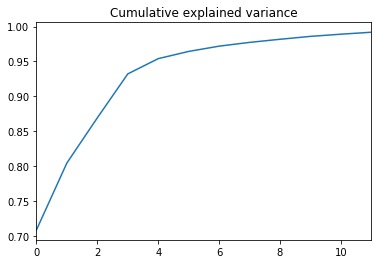

In [12]:
pd.Series(pca.explained_variance_ratio_).cumsum().plot()
plt.title("Cumulative explained variance")

#### K-Means 
##### Determining cluster count

In [13]:
# Calculating the sum of squared distances from each point 
# to its assigned center(distortions).
inertia = []
for k in tqdm_notebook(range(1, 15)): # Just 2 classes, but try up to 15
    kmeans = KMeans(n_clusters=k, n_init=100, 
                    random_state=RANDOM_STATE, n_jobs=1).fit(df_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

_Although 13 clusters seems to be the ideal number of groups_

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

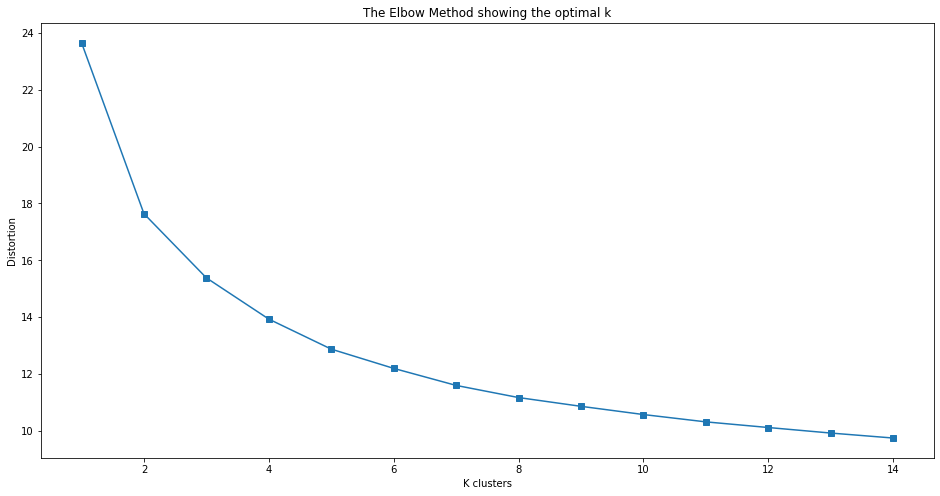

In [14]:
# Elbow plot
plt.figure(figsize=(16,8))
plt.plot(range(1, 15), inertia, marker='s');
plt.xlabel('K clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

_Will simply use 8 groupings_

In [16]:
kmeans = KMeans(n_clusters=8, 
                n_init=100, 
                random_state=RANDOM_STATE, 
                n_jobs=1)
kmeans.fit(df_pca)
#cluster_labels = kmeans.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=100, n_jobs=1, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

In [17]:
print (kmeans.labels_.shape)
df_clusters = pd.DataFrame( kmeans.labels_); df_clusters.columns = ["Cluster"]

(79231,)


#### Concatinate all information into a single DF 

In [11]:
df2 = pd.concat( [ df[["YQuarter","Ticker", 'gsector', 'Date']], # Categorical / Date
                   scaled_data, # Independent Features
                   df_clusters, # Categorical 
                   df_pca], axis=1) # Independent Features - Factors  

# Rename features into categorical
df2['gsector'] = ["Sector_"+str(x) for x in df2['gsector'].values]
#f2['Cluster'] = ["Cluster_"+str(x) for x in df2['Cluster'].values]

df2.head(1)

NameError: name 'df_clusters' is not defined

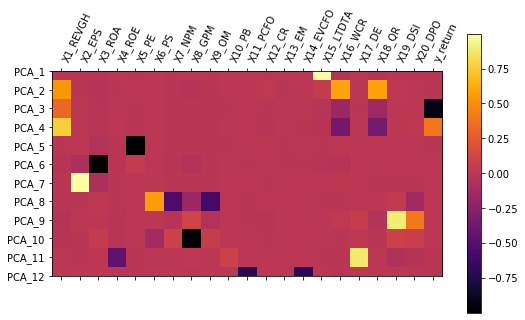

In [63]:
# FEATURE VARIANCE CONTRIBUTION TO PCA COMPONENTS
plt.matshow(pca.components_,cmap='inferno')  #'viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.yticks(range(len(df_pca.columns)),
            df_pca.columns,fontsize=10)
plt.colorbar()
plt.xticks(range(len(df.drop(["YQuarter","Ticker" , 'gsector', 'Date'],axis=1).columns)),
                     df.drop(["YQuarter","Ticker" ,'gsector', 'Date'],axis=1).columns,rotation=65,ha='left')
# plt.figure(figsize=(18,25))
plt.show()# 

#### Save to Database

In [74]:
conn = sql.connect("data/data.db")
cur = conn.cursor()
df2.to_sql("clean_data",conn,index=False,if_exists='replace')
conn.close()

In [65]:
# SAVE PCA RESULTS 
pca_dump = [df_pca, pca.components_, pca.explained_variance_, pca.explained_variance_ratio_ ]
with open("data/pca.pkl", "wb") as f:
    pickle.dump(pca_dump, f)

**INDIVISUAL TABLES MAKE FOR FASTER RESULTS**

In [ ]:
conn = sql.connect("data/data.db")
cur = conn.cursor()
# PCA
np.exp(df.select_dtypes(include=['float64']).iloc[:,-12:]).to_sql("pca",conn,index=False,if_exists='replace')
# Features
df.select_dtypes(include=['float64']).iloc[:, :20].to_sql("features",conn,index=False,if_exists='replace')
# Clusters
df[['Cluster']].to_sql("clusters",conn,index=False,if_exists='replace')
# Index 
df.iloc[:,:4].to_sql("other",conn,index=False,if_exists='replace')
conn.close()

#### Upsample data by year 

================================================  END   =============================================================